In [2]:
pip install --upgrade pip setuptools

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf


from functools import partial
from keras import backend as K
from keras import callbacks
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

In [5]:
folds = pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv")

In [6]:
folds.head()

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [7]:
df = pd.DataFrame(folds.iloc[:7909])
df.head()

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [8]:
df["label"] = df["filename"].apply(lambda x: x.split("/")[3])
df.head()

,fold,mag,grp,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign


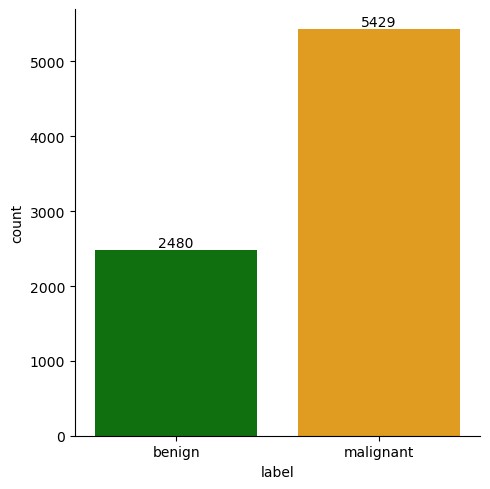

In [9]:
# Striping any leading/trailing whitespace from the below labels
df['label'] = df['label'].str.strip()

# Creating the plot with counts
g = sns.catplot(x="label", data=df, kind="count", hue="label", palette=['green', 'orange'], legend=False)

# This code is to ensure that the bar data labels is served to all the bars
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)

# visualization of the plot
plt.show()

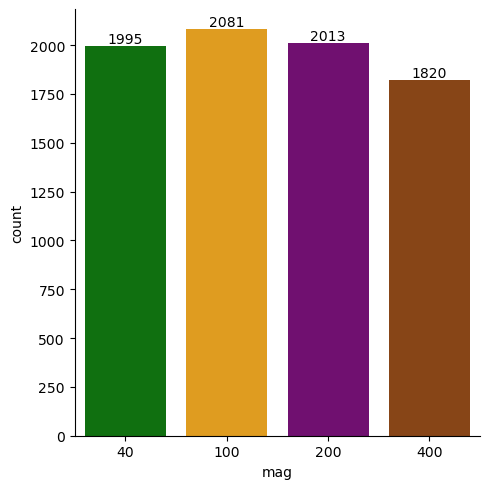

In [10]:
g = sns.catplot(x="mag", data=df, kind="count", hue="mag", palette=['green', 'orange', 'purple', "#9a4204"], legend=False)

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)

# Show the plot
plt.show()

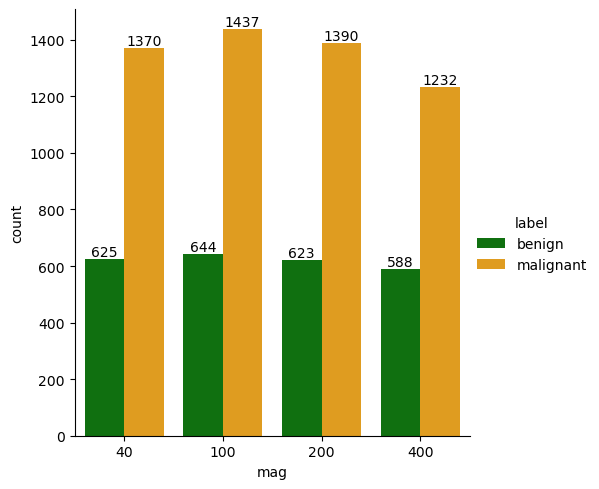

In [11]:
g = sns.catplot(x="mag", data=df, hue="label", kind="count", palette=['green', 'orange'])
for ax in g.axes.flat:
    for c in ax.containers:
        ax.bar_label(c)
plt.show()

Split the data and load images

In [13]:
df['label_int'] = df.label.apply(lambda x: ['benign', 'malignant'].index(x))

In [14]:
df

,fold,mag,grp,filename,label,label_int
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
...,...,...,...,...,...,...
7904,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,1
7905,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,1
7906,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,1
7907,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,1


In [15]:
random_state = 42

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=42)

In [17]:
train_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/"+ X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices(( "/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/"+ X_test, y_test))

Build and evaluate a model
Created model: VGG-16 + fully-connected layer.

In [77]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [79]:
from functools import partial
from keras import backend as K
from keras import callbacks
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

In [81]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [64, 64]) / 255.0
    return img, label

In [83]:
X_trainset = train_loader.shuffle(len(X_train)).map(parse_image).map(resize_rescale).batch(64)
X_testset = test_loader.shuffle(len(X_test)).map(parse_image).map(resize_rescale).batch(64)

2024-07-09 23:34:37.821135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


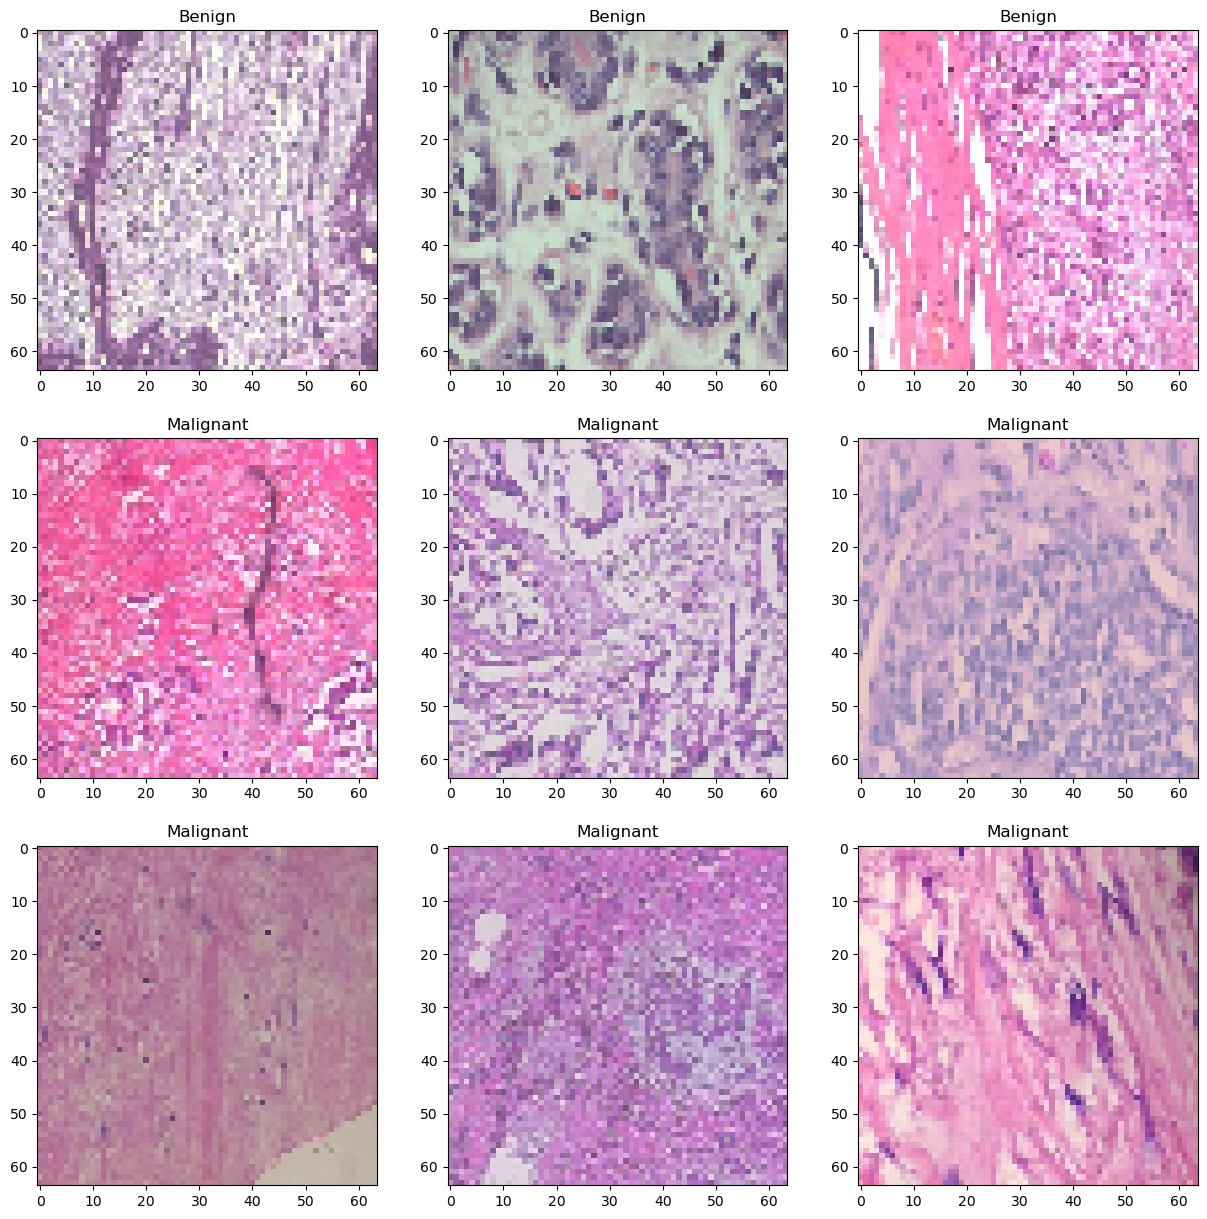

In [85]:
# Visualize sample images
fig = plt.figure(figsize=(15, 15))
for i, img in enumerate(X_trainset.take(9)):
    ax = fig.add_subplot(3, 3, i+1)
    if tf.keras.backend.get_value(img[1][i]) == 0:
       ax.title.set_text("Benign")
    else:
       ax.title.set_text("Malignant")
    plt.imshow(img[0][i])
plt.show()

In [87]:
from tensorflow.keras.applications import VGG16

In [89]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [91]:
X_train_features = []
y_train_labels = []
for img, label in X_trainset:
    features = base_model.predict(img)
    X_train_features.append(features)
    y_train_labels.extend(label.numpy())

X_train_features = np.concatenate(X_train_features, axis=0)
y_train_labels = np.array(y_train_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

2024-07-09 23:38:20.759802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [92]:
X_test_features = []
y_test_labels = []
for img, label in X_testset:
    features = base_model.predict(img)
    X_test_features.append(features)
    y_test_labels.extend(label.numpy())

X_test_features = np.concatenate(X_test_features, axis=0)
y_test_labels = np.array(y_test_labels)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


2024-07-09 23:38:34.479464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [95]:
X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)

In [97]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_features_flat, y_train_labels)


In [99]:
unique, counts = np.unique(y_train_resampled, return_counts=True)
print("Class distribution after oversampling:", dict(zip(unique, counts)))

Class distribution after oversampling: {0: 4357, 1: 4357}


In [101]:
# Scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test_features_flat = scaler.transform(X_test_features_flat)


In [105]:
# Build and compile the classification model
model = Sequential([
    Input(shape=(X_train_resampled.shape[1],)),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [107]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [109]:
EPOCHS = 100
history = model.fit(X_train_resampled, y_train_resampled, epochs=EPOCHS, validation_data=(X_test_features_flat, y_test_labels))

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7626 - loss: 0.6157 - val_accuracy: 0.8173 - val_loss: 0.5268
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8871 - loss: 0.2851 - val_accuracy: 0.8300 - val_loss: 0.5761
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9296 - loss: 0.1828 - val_accuracy: 0.8357 - val_loss: 0.6255
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9534 - loss: 0.1327 - val_accuracy: 0.8426 - val_loss: 0.6958
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9591 - loss: 0.1260 - val_accuracy: 0.8268 - val_loss: 0.9526
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9630 - loss: 0.1097 - val_accuracy: 0.8306 - val_loss: 0.9609
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9677 - loss: 0.1047 - val_accuracy: 0.8388 - val_loss: 1.0668
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9821 - loss: 0.0615 - val_accu

In [111]:
loss, accuracy = model.evaluate(X_test_features_flat, y_test_labels)
print(f"Test Accuracy: {accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.8613 - loss: 3.7026
Test Accuracy: 0.8457648754119873


In [113]:
y_pred = model.predict(X_test_features_flat)
y_pred = (y_pred > 0.5).astype(int)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


In [115]:
print(f"Predicted labels: {np.unique(y_pred, return_counts=True)}")
print(f"True labels: {np.unique(y_test_labels, return_counts=True)}")

Predicted labels: (array([0, 1]), array([ 464, 1118]))
True labels: (array([0, 1]), array([ 510, 1072]))


In [117]:
print(classification_report(y_test_labels, y_pred))
conf_mat = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:\n", conf_mat)

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       510
           1       0.87      0.91      0.89      1072

    accuracy                           0.85      1582
   macro avg       0.83      0.81      0.82      1582
weighted avg       0.84      0.85      0.84      1582

Confusion Matrix:
 [[365 145]
 [ 99 973]]


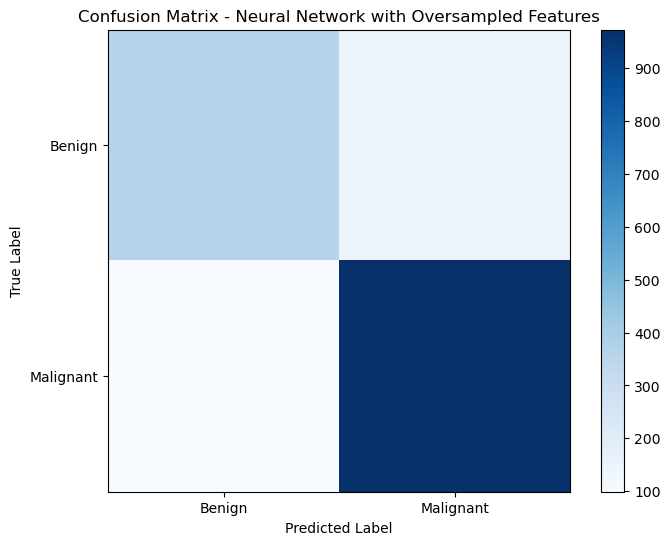

In [119]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Neural Network with Oversampled Features')
plt.colorbar()
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.yticks([0, 1], ['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [121]:
from sklearn.metrics import roc_curve, auc

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step


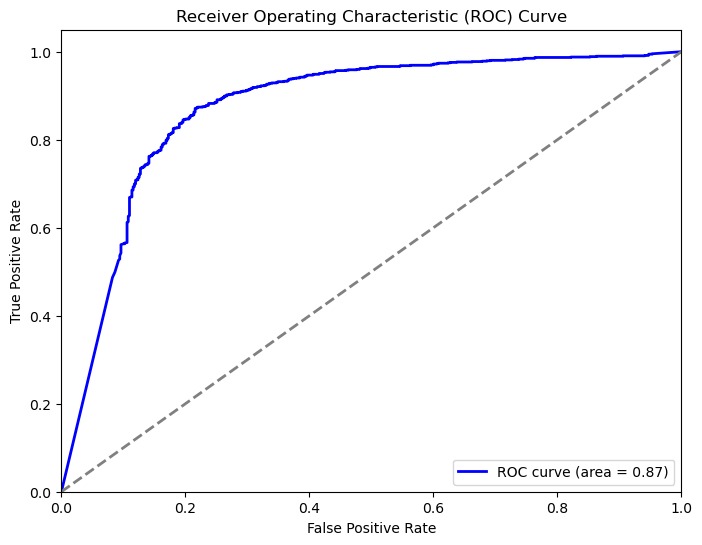

In [123]:
fpr, tpr, thresholds = roc_curve(y_test_labels, model.predict(X_test_features_flat))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()